# Kaggle上的titanic disaster数据分类问题

**题目中提到的重要信息：**
* 这是一个二分类问题，根据旅客的信息判断旅客是否可以在这场灾难中存活下来（0 = No, 1 = Yes）
* 存活下来除了有运气的成分之外，有一些人更有可能存活下来：women、children、the upper-class

根据参考文献[1]中的内容，计划workflow如下：
1. 数据集清理和格式化
2. 探索性数据分析
3. 特征工程和特征选择
4. 基于性能指标比较几种机器学习模型
5. 对最佳模型执行超参数调整
6. 在测试集上评估最佳模型
7. 解释模型结果
8. 得出结论

# Imports

In [1]:
import pandas as pd
import numpy as np
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 60)

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams['font.size']=24

from IPython.core.pylabtools import figsize

import seaborn as sns
sns.set(font_scale=1.5)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# 1. 数据处理
## 1.1 加载数据

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


**这里是数据中每一个字段的具体含义：**

| Tables        | Are           | Cool  |
| ------------- |:-------------:| -----:|
|survival	|Survival	|0 = No, 1 = Yes|
|pclass	|Ticket class	|1 = 1st, 2 = 2nd, 3 = 3rd|
|sex	|Sex	|
|Age	|Age in years|	
|sibsp	|# of siblings / spouses aboard the Titanic	|
|parch	|# of parents / children aboard the Titanic	|
|ticket	|Ticket number	|
|fare	|Passenger fare	|
|cabin	|Cabin number	|
|embarked	|Port of Embarkation	|C = Cherbourg, Q = Queenstown, S = Southampton|

**题目中的Overview中提到了，women、children、the upper-class存活下来的概率更大，所以接下来，我们可能要更加注重pclass、sex、age这三个字段**

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


使用data.info()看到，所有的列都使用了正确的数据类型，并没有出现包含数字的列被存储为object类型

## 1.2 处理异常值


In [4]:
# 使用data.describe()查看数据的统计信息
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Text(0.5,1,'Survival Distribution')

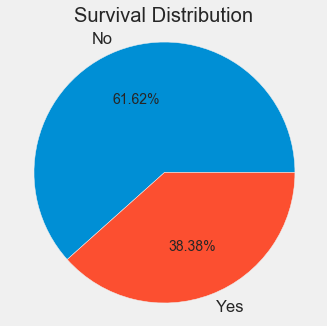

In [5]:
figsize(5,5)
plt.style.use('fivethirtyeight')
counts = train_data['Survived'].value_counts()
plt.pie(counts, labels=['No', 'Yes'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Survival Distribution')

Text(0.5,1,'Age Distribution')

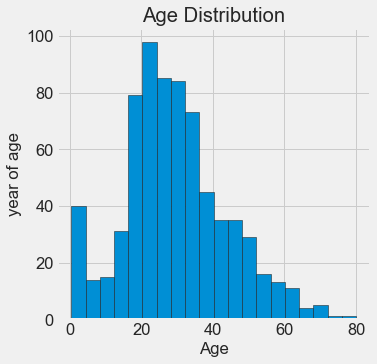

In [6]:
figsize(5,5)
plt.hist(train_data['Age'].dropna(), bins=20, edgecolor='k')
plt.xlabel('Age')
plt.ylabel('year of age')
plt.title('Age Distribution')

Text(0.5,1,'Ticket Class Distribution')

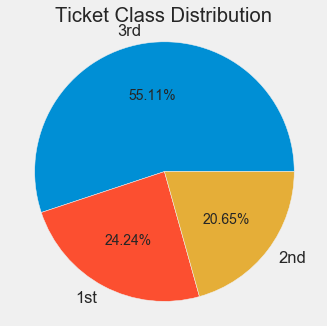

In [7]:
figsize(5,5)
counts = train_data['Pclass'].value_counts()
plt.pie(counts, labels=['3rd', '1st', '2nd'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Ticket Class Distribution')

male      577
female    314
Name: Sex, dtype: int64


Text(0.5,1,'Sex Distribution')

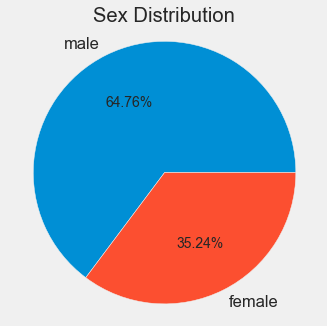

In [8]:
figsize(5,5)
counts = train_data['Sex'].value_counts()
print(counts)
plt.pie(counts, labels=['male', 'female'], autopct='%1.2f%%')
plt.axis('equal')
plt.title('Sex Distribution')

## 1.3 处理缺失值

In [9]:
print('Train columns with null values:\n', train_data.isnull().sum() / train_data.shape[0])
print("-"*10)

print('Test/Validation columns with null values:\n', test_data.isnull().sum() / test_data.shape[0])
print("-"*10)

Train columns with null values:
 PassengerId    0.000000
Survived       0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.198653
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.000000
Cabin          0.771044
Embarked       0.002245
dtype: float64
----------
Test/Validation columns with null values:
 PassengerId    0.000000
Pclass         0.000000
Name           0.000000
Sex            0.000000
Age            0.205742
SibSp          0.000000
Parch          0.000000
Ticket         0.000000
Fare           0.002392
Cabin          0.782297
Embarked       0.000000
dtype: float64
----------


In [10]:
for dataset in [train_data, test_data]:    
    dataset['Age'].fillna(dataset['Age'].median(), inplace = True)

    dataset['Embarked'].fillna(dataset['Embarked'].mode()[0], inplace = True)

    dataset['Fare'].fillna(dataset['Fare'].median(), inplace = True)
    
drop_column = ['Cabin','PassengerId', 'Ticket']
train_data.drop(drop_column, axis=1, inplace = True)

print(train_data.isnull().sum())
print("-"*10)
print(test_data.isnull().sum())

Survived    0
Pclass      0
Name        0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64
----------
PassengerId      0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          327
Embarked         0
dtype: int64


# 2. 特征工程与特征选择

## 2.2 特征工程

In [11]:
def create_features_for_data(data):
    data['FamilySize'] = data ['SibSp'] + data['Parch'] + 1
    
    data['IsAlone'] = 1
    data['IsAlone'].loc[data['FamilySize'] > 1] = 0 
    
    data['Title'] = data['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    title_names = (data['Title'].value_counts() < 10) 
    data['Title'] = data['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
    
    data['FareBin'] = pd.qcut(data['Fare'], 4)
    data['AgeBin'] = pd.cut(data['Age'].astype(int), 5)
    
    label = LabelEncoder()
    features = ['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin']
    for f in features:
        data[f+'_Code'] = label.fit_transform(data[f])
    
    data = data.drop(columns=['Sex', 'Embarked', 'Title', 'FareBin', 'AgeBin', 'Name'])
    return data

train_data = create_features_for_data(train_data)
test_data = create_features_for_data(test_data)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (891, 13)


,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,22.0,1,0,7.2500,2,0,1,2,3,0,1
1,1,1,38.0,1,0,71.2833,2,0,0,0,4,3,2
2,1,3,26.0,0,0,7.9250,1,1,0,2,2,1,1
3,1,1,35.0,1,0,53.1000,2,0,0,2,4,3,2
4,0,3,35.0,0,0,8.0500,1,1,1,2,3,1,2


## 2.3 特征选择（去除共线特征）


In [12]:
def print_collinear_features(x, threshold):
    '''
    Objective:
       删除数据帧中相关系数大于阈值的共线特征。 删除共线特征可以帮助模型泛化并提高模型的可解释性。
        
    Inputs: 
        阈值：删除任何相关性大于此值的特征
    
    Output: 
        仅包含非高共线特征的数据帧
    '''
    
    # 不要删除能源之星得分之间的相关性
    y = x['Survived']
    x = x.drop(columns = ['Survived'])
    
    # 计算相关性矩阵
    corr_matrix = x.corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    # 迭代相关性矩阵并比较相关性
    for i in iters:
        for j in range(i):
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)
            
            # 如果相关性超过阈值
            if val >= threshold:
                # 打印有相关性的特征和相关值
                print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                drop_cols.append(col.values[0])


In [13]:
print_collinear_features(train_data, 0.6)

FamilySize | SibSp | 0.89
FamilySize | Parch | 0.78
FareBin_Code | Pclass | 0.63
AgeBin_Code | Age | 0.94


In [14]:
drop_columns = ['Age', 'SibSp', 'Parch']
train_data = train_data.drop(columns=drop_columns)
test_data = test_data.drop(columns=drop_columns)
print('train data shape:',train_data.shape)
train_data.head(5)

train data shape: (891, 10)


,Survived,Pclass,Fare,FamilySize,IsAlone,Sex_Code,Embarked_Code,Title_Code,FareBin_Code,AgeBin_Code
0,0,3,7.2500,2,0,1,2,3,0,1
1,1,1,71.2833,2,0,0,0,4,3,2
2,1,3,7.9250,1,1,0,2,2,1,1
3,1,1,53.1000,2,0,0,2,4,3,2
4,0,3,8.0500,1,1,1,2,3,1,2


## 2.3 特征缩放

In [15]:
# max_min_scaler = lambda x : (x-np.min(x))/(np.max(x)-np.min(x))
# train_data[['Age', 'Fare']] = train_data[['Age', 'Fare']].apply(max_min_scaler)
# train_data.head(5)

## 2.4 划分训练集合测试集

In [16]:
targets = train_data['Survived']
features = train_data.drop(columns=['Survived'])

X, X_valid, Y, Y_valid = train_test_split(features, targets, test_size = 0.3, random_state = 42)

print(X.shape)
print(X_valid.shape)
print(Y.shape)
print(Y_valid.shape)

(623, 9)
(268, 9)
(623,)
(268,)



# 3 对数据进行探索性分析


In [17]:
correlations_matrix = train_data.corr()['Survived'].sort_values()
print(correlations_matrix, '\n')

Sex_Code        -0.543351
Pclass          -0.338481
IsAlone         -0.203367
Embarked_Code   -0.167675
Title_Code      -0.083292
AgeBin_Code     -0.044492
FamilySize       0.016639
Fare             0.257307
FareBin_Code     0.299357
Survived         1.000000
Name: Survived, dtype: float64 



In [18]:
for x in train_data:
    if train_data[x].dtype != 'float64' and x not in ['Survived', 'Name']:
        print('Survival Correlation by:', x)
        print(train_data[[x, 'Survived']].groupby(x, as_index=False).mean())
        print('-' * 10, '\n')

Survival Correlation by: Pclass
   Pclass  Survived
0       1  0.629630
1       2  0.472826
2       3  0.242363
---------- 

Survival Correlation by: FamilySize
   FamilySize  Survived
0           1  0.303538
1           2  0.552795
2           3  0.578431
3           4  0.724138
4           5  0.200000
5           6  0.136364
6           7  0.333333
7           8  0.000000
8          11  0.000000
---------- 

Survival Correlation by: IsAlone
   IsAlone  Survived
0        0  0.505650
1        1  0.303538
---------- 

Survival Correlation by: Sex_Code
   Sex_Code  Survived
0         0  0.742038
1         1  0.188908
---------- 

Survival Correlation by: Embarked_Code
   Embarked_Code  Survived
0              0  0.553571
1              1  0.389610
2              2  0.339009
---------- 

Survival Correlation by: Title_Code
   Title_Code  Survived
0           0  0.575000
1           1  0.444444
2           2  0.697802
3           3  0.156673
4           4  0.792000
---------- 

Survival Co

# 4.基于性能指标比较几种机器学习模型

In [19]:
from sklearn.preprocessing import Imputer, MinMaxScaler
from sklearn import model_selection
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
import scipy.stats

## 4.1 建立Baseline

In [20]:
baseline_accuracy = 1 - np.sum(targets)/targets.shape[0]
print('The baseline guess is %d' % 0)
print("Baseline Performance on the test set: accuracy = %0.4f" % baseline_accuracy)

The baseline guess is 0
Baseline Performance on the test set: accuracy = 0.6162


## 4.2 需要评估的模型

In [21]:
# machine learning algorithm
MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(n_estimators=10),
    ensemble.BaggingClassifier(n_estimators=10),
    ensemble.ExtraTreesClassifier(n_estimators=10),
    ensemble.GradientBoostingClassifier(n_estimators=10),
    ensemble.RandomForestClassifier(n_estimators=10),

#     Gaussian Processes
    gaussian_process.GaussianProcessClassifier(),
    
    #GLM
    linear_model.LogisticRegressionCV(cv=3, max_iter=1000),
    linear_model.PassiveAggressiveClassifier(max_iter=1000, tol=1e-3),
    linear_model.RidgeClassifierCV(cv=3),
    linear_model.SGDClassifier(max_iter=1000, tol=1e-3),
    linear_model.Perceptron(max_iter=1000, tol=1e-3),
    
    #Navies Bayes
    naive_bayes.BernoulliNB(),
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True, gamma='scale'),
    svm.NuSVC(probability=True, gamma='scale'),
#     svm.LinearSVC(max_iter=1000),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    tree.ExtraTreeClassifier(),
    
    #Discriminant Analysis
    discriminant_analysis.LinearDiscriminantAnalysis(),
    discriminant_analysis.QuadraticDiscriminantAnalysis()
]

MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Train Accuracy Mean', 'MLA Test Accuracy Mean', 
               'MLA Test Accuracy 3*STD', 'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)
row_index = 0
cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .6, random_state = 0)
for alg in MLA:
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    cv_results = model_selection.cross_validate(alg, X, Y, cv  = cv_split, return_train_score=True)
    
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3
    
    row_index+=1
    
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


,MLA Name,MLA Parameters,MLA Train Accuracy Mean,MLA Test Accuracy Mean,MLA Test Accuracy 3*STD,MLA Time
1,BaggingClassifier,"{'verbose': 0, 'warm_start': False, 'n_jobs': ...",0.946381,0.828877,0.0486602,0.0091712
0,AdaBoostClassifier,"{'random_state': None, 'learning_rate': 1.0, '...",0.835925,0.827807,0.0781993,0.0089725
3,GradientBoostingClassifier,"{'warm_start': False, 'max_features': None, 'c...",0.834316,0.827807,0.0748357,0.00558543
19,QuadraticDiscriminantAnalysis,"{'priors': None, 'store_covariances': None, 's...",0.824129,0.826738,0.0297549,0.00139537
4,RandomForestClassifier,"{'warm_start': False, 'max_features': 'auto', ...",0.948525,0.813904,0.0559431,0.00777841
16,DecisionTreeClassifier,"{'max_features': None, 'criterion': 'gini', 'm...",0.957641,0.809626,0.0852535,0.0017941
8,RidgeClassifierCV,"{'cv': 3, 'store_cv_values': False, 'scoring':...",0.8,0.806417,0.0311081,0.0295296
18,LinearDiscriminantAnalysis,"{'tol': 0.0001, 'store_covariance': False, 'so...",0.805362,0.804278,0.0217615,0.00198793
6,LogisticRegressionCV,"{'cv': 3, 'Cs': 10, 'random_state': None, 'tol...",0.806434,0.80107,0.0371417,0.201063
12,GaussianNB,"{'priors': None, 'var_smoothing': 1e-09}",0.796783,0.793583,0.0492908,0.00179639


Text(0,0.5,'Algorithm')

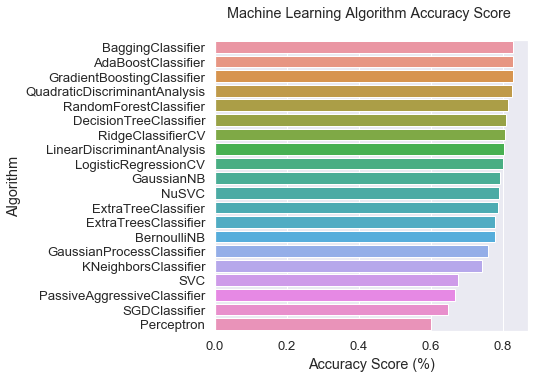

In [22]:
sns.set(font_scale=1.2)
sns.barplot(x = 'MLA Test Accuracy Mean', y = 'MLA Name', data=MLA_compare)
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

## 4.3 调节超参数
### 4.3.1 Randomed Search CV 

In [23]:
# data1_x_bin = ['Sex_Code','Pclass', 'Embarked_Code', 'Title_Code', 
#                'FamilySize', 'AgeBin_Code', 'FareBin_Code']
# X = X[data1_x_bin]
# X_valid = X_valid[data1_x_bin]

n_estimators = scipy.stats.randint(low=10, high=1000)
min_samples_leaf = [1,2,4,6,8]
min_samples_split = [2, 4, 6, 10]
max_depth = [2,4,6,8,10,None]
max_features = ['auto', 'sqrt', 'log2', None]

hyperparameter_grid = {'n_estimators': n_estimators,
                       'max_depth': max_depth,
                       'min_samples_leaf': min_samples_leaf,
                       'min_samples_split': min_samples_split,
                       'max_features': max_features,
                       'max_depth': max_depth}

model = ensemble.RandomForestClassifier(random_state=0)
random_search = model_selection.RandomizedSearchCV(estimator=model,
                                               param_distributions=hyperparameter_grid,
                                               cv=8, n_iter=50, scoring='accuracy',
                                               n_jobs = -1, verbose = 1, 
                                               return_train_score = True,
                                               random_state=0)

In [24]:
random_search.fit(X, Y)

Fitting 8 folds for each of 50 candidates, totalling 400 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   22.0s
[Parallel(n_jobs=-1)]: Done 400 out of 400 | elapsed:   43.2s finished
c:\myprogram\python35\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomizedSearchCV(cv=8, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=50, n_jobs=-1,
          param_distributions={'min_samples_leaf': [1, 2, 4, 6, 8], 'max_depth': [2, 4, 6, 8, 10, None], 'max_features': ['auto', 'sqrt', 'log2', None], 'min_samples_split': [2, 4, 6, 10], 'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000002672F9BA7F0>},
          pre_dispatch='2*n_jobs', random_state=0, refit=True,
          return_train_score=True, scoring='accuracy', verbose=1)

In [25]:
random_search_result = pd.DataFrame(random_search.cv_results_).sort_values('mean_test_score', ascending = False)
random_search_result.head(10)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,split4_test_score,split4_train_score,split5_test_score,split5_train_score,split6_test_score,split6_train_score,split7_test_score,split7_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
30,0.925278,0.075175,0.833066,0.856687,4,log2,2,2,788,"{'min_samples_leaf': 2, 'max_depth': 4, 'max_f...",1,0.794872,0.860550,0.858974,0.851376,0.910256,0.847706,0.820513,0.856881,0.769231,0.855046,0.820513,0.869725,0.769231,0.867890,0.922078,0.844322,0.068344,0.007994,0.055243,0.008477
22,0.276137,0.020695,0.833066,0.863337,4,None,1,10,207,"{'min_samples_leaf': 1, 'max_depth': 4, 'max_f...",1,0.794872,0.867890,0.871795,0.856881,0.923077,0.855046,0.820513,0.869725,0.794872,0.871560,0.794872,0.856881,0.769231,0.877064,0.896104,0.851648,0.016162,0.002216,0.052642,0.008706
4,0.958813,0.078540,0.833066,0.856458,4,sqrt,1,4,926,"{'min_samples_leaf': 1, 'max_depth': 4, 'max_f...",1,0.794872,0.862385,0.858974,0.851376,0.910256,0.847706,0.820513,0.856881,0.769231,0.855046,0.820513,0.867890,0.769231,0.867890,0.922078,0.842491,0.017346,0.001979,0.055243,0.008633
1,0.383350,0.026554,0.833066,0.892916,8,None,2,10,287,"{'min_samples_leaf': 2, 'max_depth': 8, 'max_f...",1,0.807692,0.891743,0.858974,0.889908,0.871795,0.893578,0.807692,0.899083,0.794872,0.902752,0.858974,0.889908,0.769231,0.891743,0.896104,0.884615,0.005416,0.002539,0.041244,0.005303
0,1.087719,0.070935,0.831461,0.902316,10,None,1,10,773,"{'min_samples_leaf': 1, 'max_depth': 10, 'max_...",5,0.820513,0.906422,0.858974,0.900917,0.858974,0.900917,0.807692,0.906422,0.782051,0.906422,0.858974,0.897248,0.782051,0.897248,0.883117,0.902930,0.014349,0.004095,0.036210,0.003644
45,0.246092,0.021193,0.831461,0.856000,4,log2,1,6,217,"{'min_samples_leaf': 1, 'max_depth': 4, 'max_f...",5,0.794872,0.858716,0.858974,0.849541,0.910256,0.847706,0.820513,0.855046,0.756410,0.858716,0.807692,0.869725,0.769231,0.869725,0.935065,0.838828,0.015287,0.001635,0.060350,0.009986
15,0.131648,0.014960,0.831461,0.860815,4,None,6,6,92,"{'min_samples_leaf': 6, 'max_depth': 4, 'max_f...",5,0.794872,0.860550,0.871795,0.853211,0.910256,0.856881,0.820513,0.867890,0.807692,0.864220,0.794872,0.864220,0.756410,0.871560,0.896104,0.847985,0.020681,0.009448,0.051222,0.007303
20,1.080115,0.072182,0.829856,0.886265,10,None,4,10,729,"{'min_samples_leaf': 4, 'max_depth': 10, 'max_...",8,0.820513,0.888073,0.858974,0.884404,0.871795,0.888073,0.794872,0.880734,0.794872,0.891743,0.858974,0.888073,0.769231,0.882569,0.870130,0.886447,0.059738,0.007121,0.037557,0.003309
18,1.353633,0.102227,0.829856,0.866088,10,None,8,10,982,"{'min_samples_leaf': 8, 'max_depth': 10, 'max_...",8,0.794872,0.867890,0.846154,0.858716,0.910256,0.866055,0.807692,0.869725,0.794872,0.880734,0.794872,0.860550,0.794872,0.867890,0.896104,0.857143,0.059036,0.016304,0.045381,0.007064
33,0.654127,0.044631,0.828250,0.897044,6,None,1,2,498,"{'min_samples_leaf': 1, 'max_depth': 6, 'max_f...",10,0.794872,0.891743,0.846154,0.893578,0.871795,0.899083,0.807692,0.904587,0.794872,0.904587,0.846154,0.889908,0.769231,0.902752,0.896104,0.890110,0.013037,0.001979,0.040678,0.006017


In [26]:
random_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=287, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

In [27]:
n_estimators = [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]
hyperparameter_grid = {'n_estimators': n_estimators}  
model = ensemble.RandomForestClassifier(**random_search.best_estimator_.get_params())

grid_search = model_selection.GridSearchCV(estimator=model,
                                           param_grid=hyperparameter_grid, 
                                           cv = 4, scoring='accuracy',
                                           verbose = 1,
                                           n_jobs = -1, 
                                           return_train_score = True)

# param_grid = {'criterion': ['gini', 'entropy'],
#               'max_depth': [2,4,6,8,10,None],
#               'random_state': [0]}
# grid_search = model_selection.GridSearchCV(tree.DecisionTreeClassifier(), param_grid=param_grid, scoring = 'roc_auc', cv = 4)


### 4.3.2 Grid Search CV

In [28]:
grid_search.fit(X, Y)

Fitting 4 folds for each of 15 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    5.9s finished


GridSearchCV(cv=4, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=287, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=1)

In [29]:
grid_search_result = pd.DataFrame(grid_search.cv_results_).sort_values('mean_test_score', ascending = False)
grid_search_result.head(5)

,mean_fit_time,mean_score_time,mean_test_score,mean_train_score,param_n_estimators,params,rank_test_score,split0_test_score,split0_train_score,split1_test_score,split1_train_score,split2_test_score,split2_train_score,split3_test_score,split3_train_score,std_fit_time,std_score_time,std_test_score,std_train_score
0,0.131143,0.011719,0.834671,0.892994,100,{'n_estimators': 100},1,0.820513,0.897216,0.852564,0.890792,0.839744,0.897216,0.825806,0.886752,0.004326,0.000827,0.012504,0.004457
12,0.860450,0.062583,0.834671,0.891921,700,{'n_estimators': 700},1,0.820513,0.892934,0.865385,0.886510,0.833333,0.897216,0.819355,0.891026,0.078391,0.004699,0.018580,0.003845
2,0.291471,0.022939,0.833066,0.892992,200,{'n_estimators': 200},3,0.820513,0.895075,0.852564,0.888651,0.833333,0.897216,0.825806,0.891026,0.012504,0.000705,0.012157,0.003350
3,0.353555,0.025183,0.833066,0.891387,250,{'n_estimators': 250},3,0.820513,0.895075,0.852564,0.888651,0.833333,0.892934,0.825806,0.888889,0.022014,0.000432,0.012157,0.002726
5,0.486450,0.040392,0.833066,0.889782,350,{'n_estimators': 350},3,0.814103,0.890792,0.858974,0.886510,0.833333,0.895075,0.825806,0.886752,0.019382,0.002285,0.016470,0.003497


In [30]:
grid_search.best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=8, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=10,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

## 4.4 在测试集上评估模型

In [31]:
def cal_accuracy(y_true, y_pred):
    return 1- np.sum(abs(y_true - y_pred)) / y_pred.shape[0]

final_model = grid_search.best_estimator_
final_pred = final_model.predict(X_valid)
accuracy = cal_accuracy(Y_valid, final_pred)
print('Final model performance on the test set:  accuracy = %0.4f.' % accuracy)

Final model performance on the test set:  accuracy = 0.8246.
